In [72]:
%load_ext autoreload
%autoreload 2
import re
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch as th 
from os.path import join
from tqdm import tqdm
from glob import glob
from collections import defaultdict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
def load_and_process_jacobians(expdir, pattern="jacobian_ref_img_w_noise_step(\d+)\.pth", 
                               operation="eigvalsh", eigvecs=None):
    """
    Load and process jacobian files to extract eigenvalues for different noise levels and steps.
    
    Args:
        expdir (str): Name of the experiment + root directory
        pattern (str): Regex pattern to match jacobian files and extract step numbers
        
    Returns:
        tuple: (step_list, noise_levels, eigvals_tsrs)
            - step_list: List of training steps
            - noise_levels: List of noise levels
            - eigvals_tsrs: Dictionary mapping noise levels to eigenvalue tensors
    """
    # expdir = join(exproot, expname)
    jacob_dir = join(expdir, "jacobian_store")
    jacob_files = sorted(glob(join(jacob_dir, "*.pth")))
    
    # Extract step numbers from filenames using regex
    file_path_by_step = {}
    for file_path in jacob_files:
        base_filename = os.path.basename(file_path)
        match = re.search(pattern, base_filename)
        if match:
            step = int(match.group(1))
            file_path_by_step[step] = file_path

    if operation == "vJv":
        eigvecs = eigvecs.cuda()
    # Sort files by step number
    step_list = sorted(file_path_by_step.keys())
    # print(step_list)
    # Dictionary to store eigenvalues for each noise level and step
    all_eigvals_col = {}
    # Process each jacobian file
    for step in tqdm(step_list):
        file_path = file_path_by_step[step]
        # Load the jacobian data
        jacob_data = torch.load(file_path)
        noise_levels = sorted(np.unique([noise_level for noise_level, data_type in jacob_data.keys()]))
        # Process each noise level in the jacobian data
        for noise_level in noise_levels:
            # Compute eigenvalues
            jacob_matrix = jacob_data[noise_level, "jacobian"]
            if operation == "eigvalsh":
                eigvals = torch.linalg.eigvalsh(jacob_matrix.cuda())
                # Sort eigenvalues in descending order
                eigvals = torch.sort(eigvals.cpu(), dim=-1, descending=True).values
            elif operation == "vJv":
                vJv_mat = eigvecs.T @ jacob_matrix.cuda() @ eigvecs
                vJv_diag = torch.diag(vJv_mat)
                eigvals = vJv_diag
            # Store the eigenvalues with the step number
            all_eigvals_col[(noise_level, step)] = eigvals

    eigvals_mats = defaultdict(list)
    noise_levels = sorted(np.unique([noise_level for noise_level, step in all_eigvals_col.keys()]))
    step_list = sorted(np.unique([step for noise_level, step in all_eigvals_col.keys()]))
    # for noise_level, step in all_eigvals_col.keys():
    for noise_level in noise_levels:
        for step in step_list:
            eigvals = all_eigvals_col[(noise_level, step)]
            eigvals_mats[noise_level].append(eigvals)

    eigvals_tsrs = dict()
    for noise_level in eigvals_mats:
        eigvals_tsrs[noise_level] = torch.stack(eigvals_mats[noise_level], dim=0)
    
    return step_list, noise_levels, eigvals_tsrs

In [75]:
def plot_eigenvalue_evolution(step_list, eigvals_tsrs, expname, eigid2show=range(1,1000,50), max_noise_levels=9, xscale="log"):
    """
    Plot the evolution of eigenvalues across training steps for different noise levels.
    
    Args:
        step_list: List of training steps
        eigvals_tsrs: Dictionary mapping noise levels to eigenvalue tensors
        expname: Experiment name for the plot title
        eigid2show: Range of eigenvalue indices to display
        max_noise_levels: Maximum number of noise levels to show
    
    Returns:
        fig: The matplotlib figure object
    """
    # Create a figure with subplots to compare different noise levels
    fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=False)
    axes = axes.flatten()
    # Plot the eigenvalues for different noise levels
    for i, noise_level in enumerate(list(eigvals_tsrs.keys())[:max_noise_levels]):
        ax = axes[i]
        eigvals_tensor = eigvals_tsrs[noise_level]
        # Plot the selected eigenvalues
        for j in eigid2show:
            ax.plot(step_list, eigvals_tensor[:, j], label=f'Eigenvalue {j+1}')
            
        ax.set_title(f'Noise Level: {noise_level}')
        ax.grid(True)
        # ax.set_yscale('log')
        ax.set_xscale(xscale)
        
        if i % 3 == 0:  # Left column
            ax.set_ylabel('Eigenvalue Magnitude')
        if i >= 6:  # Bottom row
            ax.set_xlabel('Training Step')

    plt.suptitle(f'Denoiser Jacobian Eigenvalue Magnitude Across Training Steps for Different Noise Levels \n {expname}')
    plt.tight_layout()
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3)
    return fig

In [85]:
data_Xtsr = torch.load("/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/wordnet_render_dataset/ffhq-32x32.pt")
Xtsr = (data_Xtsr - 0.5) / 0.5
pnts = Xtsr.view(Xtsr.shape[0], -1).cuda()
ndim = pnts.shape[1]
X_mean = pnts.mean(dim=0)
data_cov = torch.cov(pnts.T, correction=1)
# diagonalize the covariance matrix
data_cov_eigs, data_cov_evecs = torch.linalg.eigh(data_cov)
data_cov_eigs = data_cov_eigs.flip(0)
data_cov_evecs = data_cov_evecs.flip(1)
del data_Xtsr, Xtsr, pnts

In [87]:
data_cov_eigs

tensor([1.7339e+02, 6.0114e+01, 5.8021e+01,  ..., 2.6531e-05, 2.5508e-05,
        2.5128e-05], device='cuda:0')

In [90]:
import pickle as pkl
# Example usage
exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"
expname = "FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4_saveckpt_fewsample_longtrain"
expdir = join(exproot, expname)
savedir = join(expdir, "jacobian_summary")
os.makedirs(savedir, exist_ok=True)

In [91]:
step_list, noise_levels, eigvals_tsrs = load_and_process_jacobians(expdir, pattern="jacobian_ref_img_w_noise_step(\d+)\.pth", operation="eigvalsh")
pkl.dump({"step_list": step_list, "noise_levels": noise_levels, 
          "eigvals_tsrs": eigvals_tsrs}, open(join(savedir, f"jacobian_ref_img_w_noise_eigvalsh_summary.pkl"), "wb"))


step_list, noise_levels, eigvals_tsrs_vJv = load_and_process_jacobians(expdir, pattern="jacobian_ref_img_w_noise_step(\d+)\.pth", operation="vJv", eigvecs=data_cov_evecs)
pkl.dump({"step_list": step_list, "noise_levels": noise_levels, 
          "eigvals_tsrs": eigvals_tsrs_vJv}, open(join(savedir, f"jacobian_ref_img_w_noise_data_eigbasis_vJv_summary.pkl"), "wb"))



step_list, noise_levels, eigvals_tsrs = load_and_process_jacobians(expdir, pattern="jacobian_gauss_noise_step(\d+)\.pth", operation="eigvalsh")
pkl.dump({"step_list": step_list, "noise_levels": noise_levels, 
          "eigvals_tsrs": eigvals_tsrs}, open(join(savedir, f"jacobian_gauss_noise_eigvalsh_summary.pkl"), "wb"))



step_list, noise_levels, eigvals_tsrs_vJv = load_and_process_jacobians(expdir, pattern="jacobian_gauss_noise_step(\d+)\.pth", operation="vJv", eigvecs=data_cov_evecs)
pkl.dump({"step_list": step_list, "noise_levels": noise_levels, 
          "eigvals_tsrs": eigvals_tsrs_vJv}, open(join(savedir, f"jacobian_gauss_noise_data_eigbasis_vJv_summary.pkl"), "wb"))

  0%|          | 0/171 [00:00<?, ?it/s]

100%|██████████| 171/171 [00:39<00:00,  4.30it/s]


In [4]:
jacob_dir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4_saveckpt_fewsample_longtrain/jacobian_store"

In [101]:
savedict = pkl.load(open(join(savedir, f"jacobian_ref_img_w_noise_eigvalsh_summary.pkl"), "rb"))
savedict = pkl.load(open(join(savedir, f"jacobian_gauss_noise_eigvalsh_summary.pkl"), "rb"))
# jacobian_gauss_noise_eigvalsh_summary
step_list = savedict["step_list"]
noise_levels = savedict["noise_levels"]
eigvals_tsrs = savedict["eigvals_tsrs"]
for noise_level in eigvals_tsrs.keys():
    eigvals_tsrs[noise_level] = eigvals_tsrs[noise_level].cpu()

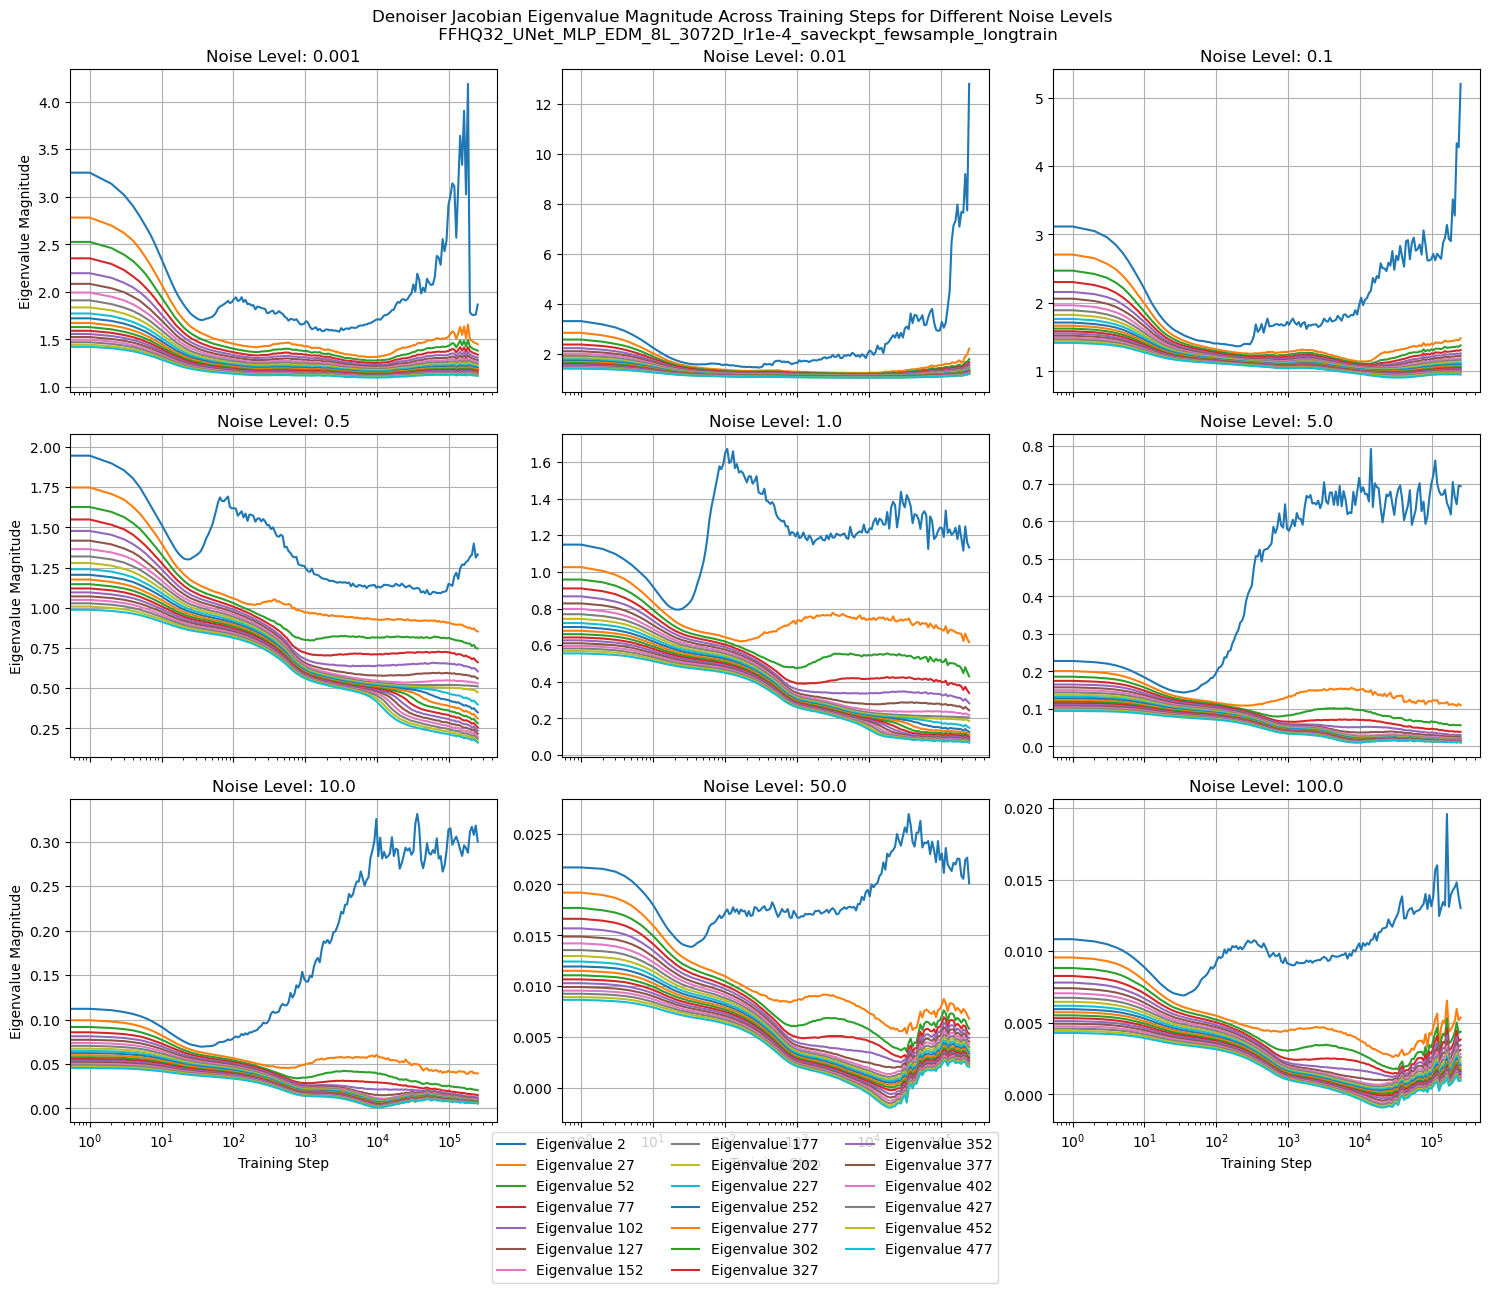

In [103]:
# Example usage
eigid2show = range(1,500,25)
fig = plot_eigenvalue_evolution(step_list, eigvals_tsrs, expname, eigid2show)
plt.show()

### Scratch

In [13]:
jacob_store = torch.load(jacob_file_path)

In [ ]:
jacob_file_path = join(jacob_dir, "jacobian_ref_img_w_noise_step000017.pth")
for noise, entry_type in jacob_store.keys():
    if entry_type == "jacobian":
        jacobian = jacob_store[noise, "jacobian"]
        # perform eigen decomposition
        eigvals, eigvecs = torch.linalg.eigh(jacobian.cuda())
        plt.plot(eigvals.cpu().numpy())
        plt.title(f"noise={noise}")
        plt.show()

In [18]:
# find paths that start with jacobian_ref_img_w_noise_step and extract the list of steps and sort them
import re
import glob

# Get all jacobian files in the directory
jacob_files = glob.glob(join(jacob_dir, "jacobian_ref_img_w_noise_step*.pth"))

# Extract step numbers from filenames using regex
step_list = []
for file_path in jacob_files:
    match = re.search(r'step(\d+)\.pth', file_path)
    if match:
        step_list.append(int(match.group(1)))

# Sort the step list
step_list.sort()

# Example of how to use a specific step
# step = step_list[0] if step_list else 0
# jacob_file_path = join(jacob_dir, f"jacobian_ref_img_w_noise_step{step:06d}.pth")

In [20]:
step_list[::10]

[0,
 10,
 21,
 39,
 74,
 138,
 259,
 484,
 905,
 1690,
 3156,
 5894,
 11007,
 20555,
 38386,
 71686,
 133871,
 249999]

In [ ]:
# Define the steps to load
steps = step_list[::10]
# Create a colormap for visualizing progression
cmap = plt.cm.viridis
norm = plt.Normalize(np.log10(min(steps) + 1), np.log10(max(steps) + 1))

# Dictionary to store eigenvalues for each noise level and step
all_eigvals = {}
# Process each step
for step_idx, step in enumerate(steps):
    jacob_file_path = join(jacob_dir, f"jacobian_ref_img_w_noise_step{step:06d}.pth")
    try:
        jacob_store = torch.load(jacob_file_path)
        
        # Plot for each noise level
        for idx, (key, entry_type) in enumerate(jacob_store.keys()):
            if entry_type == "jacobian":
                noise = key
                jacobian = jacob_store[noise, "jacobian"]
                # Perform eigen decomposition
                eigvals, eigvecs = torch.linalg.eigh(jacobian.cuda())
                eigvals_np = eigvals.cpu().numpy()
                # Find the subplot index for this noise level
                if noise not in all_eigvals:
                    all_eigvals[noise] = []
                all_eigvals[noise].append((step, eigvals_np))
        print(f"Processed step {step}")
    except FileNotFoundError:
        print(f"File not found for step {step}")

### Plot evolution of eigenvalues of Jacobian

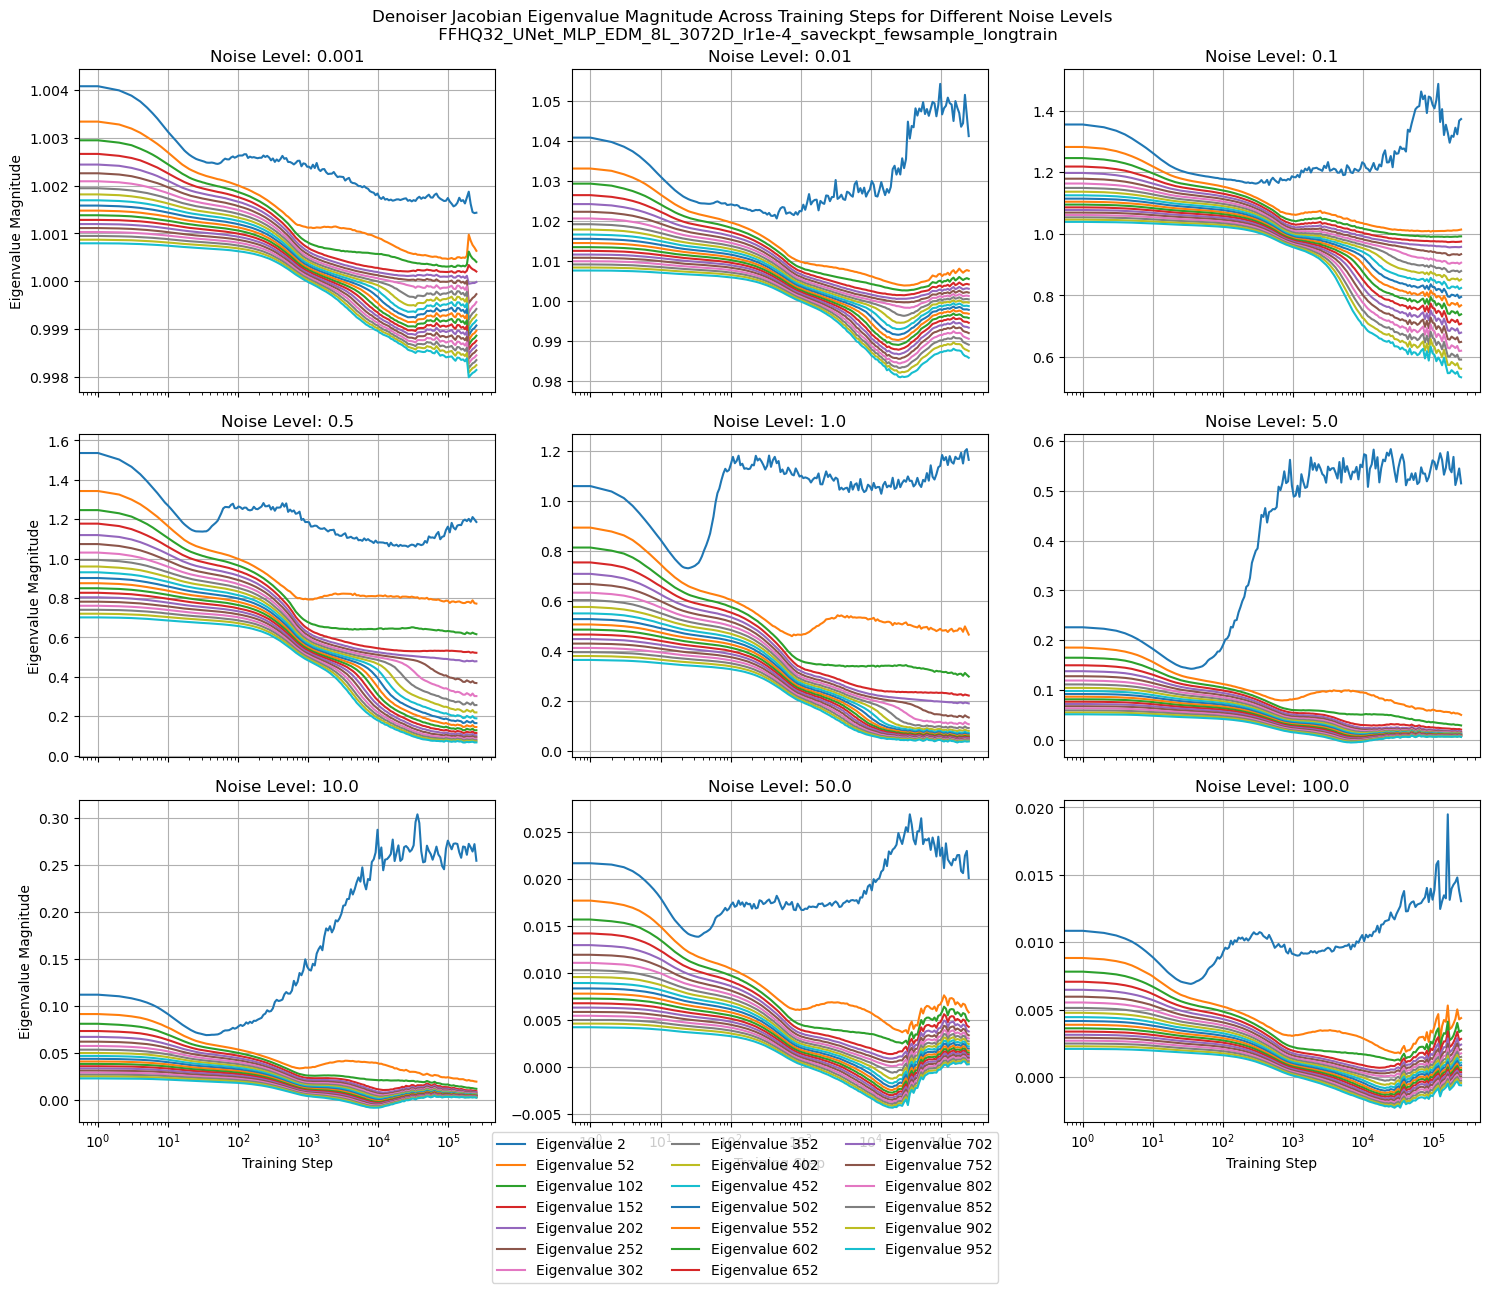

In [76]:
# Example usage
eigid2show = range(1,1000,50)
fig = plot_eigenvalue_evolution(step_list, eigvals_tsrs, expname, eigid2show)
plt.show()

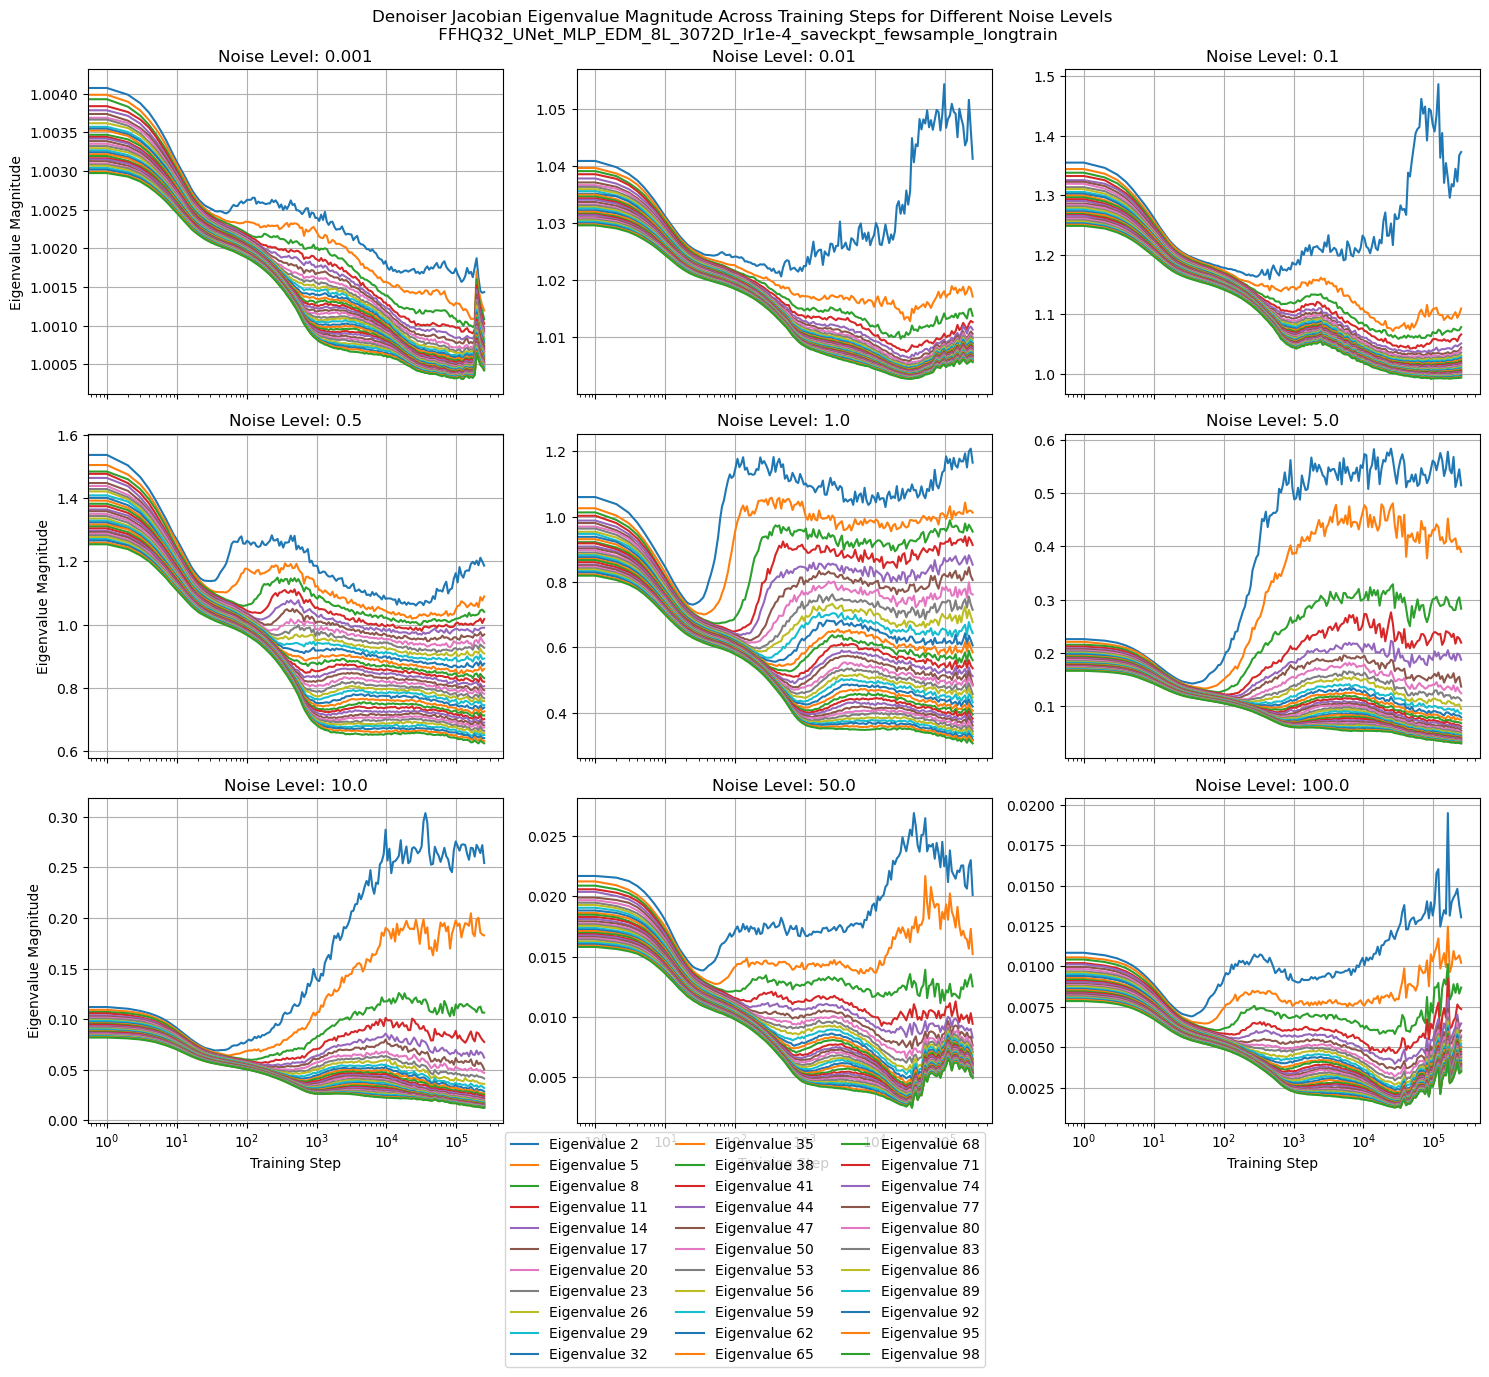

In [77]:
# Example usage
eigid2show = range(1,100,3)
fig = plot_eigenvalue_evolution(step_list, eigvals_tsrs, expname, eigid2show)
plt.show()

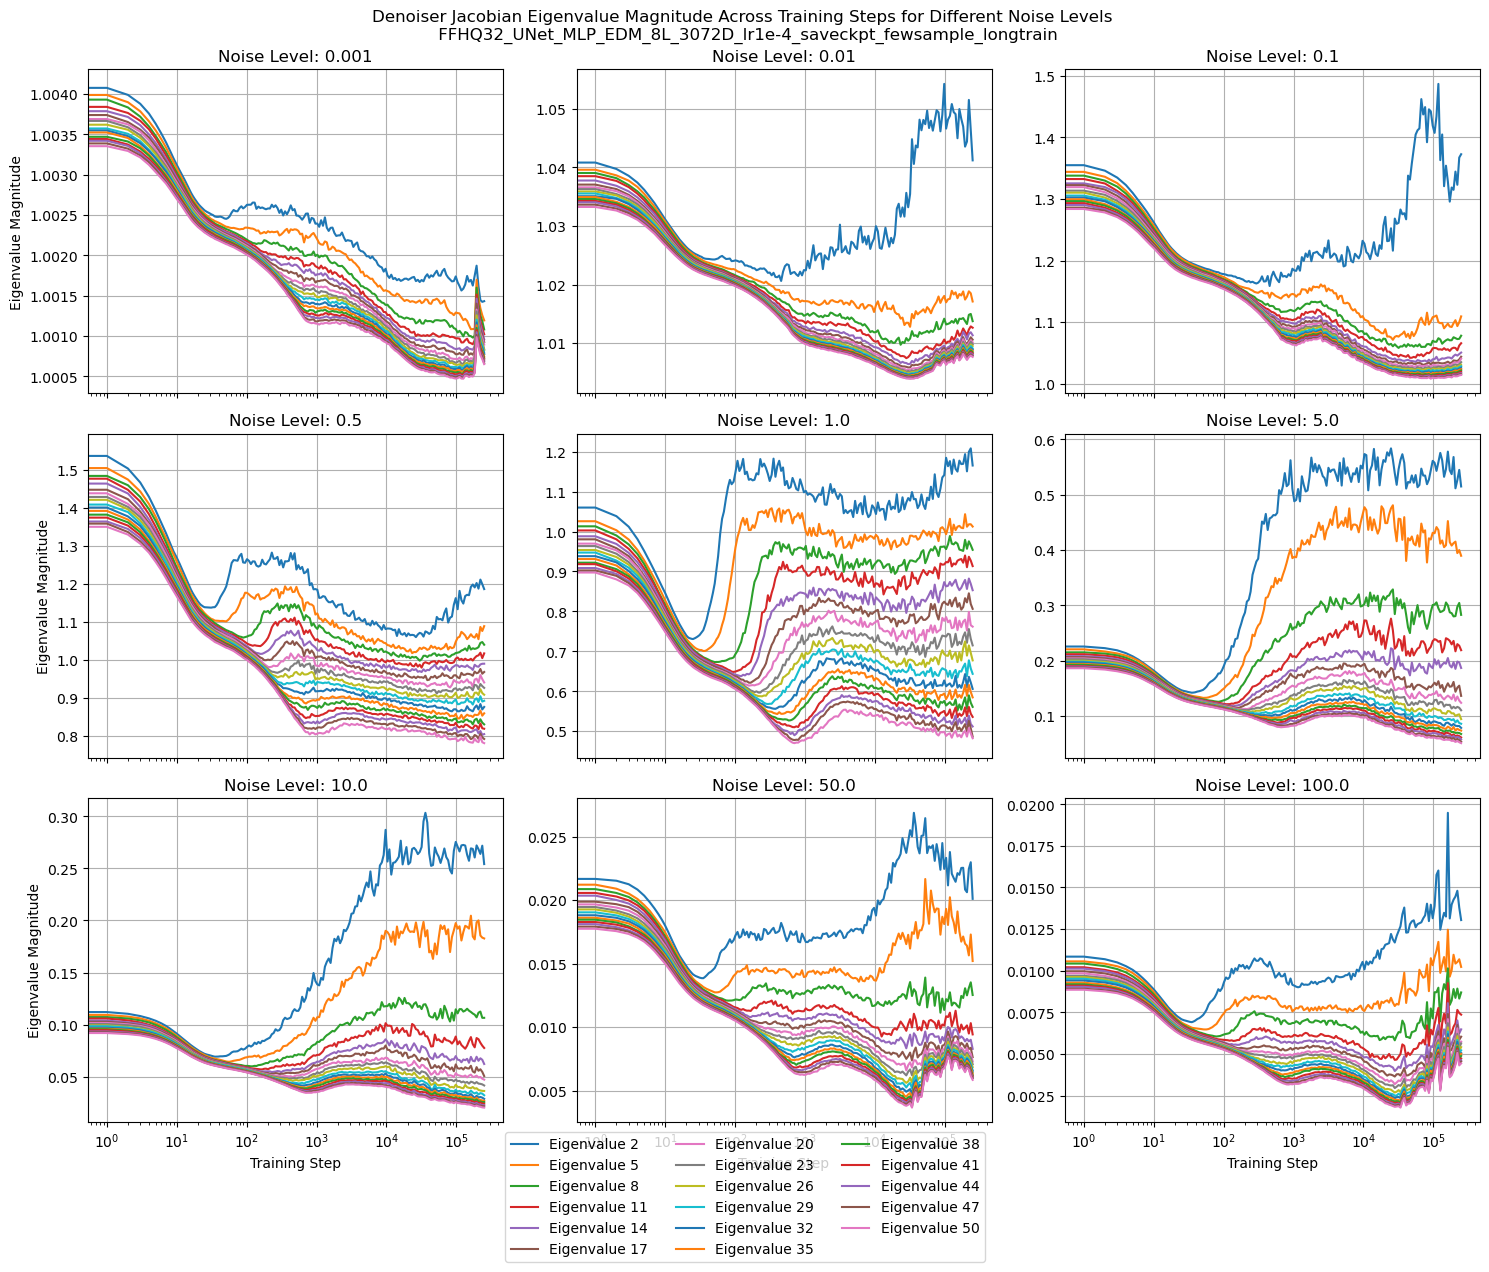

In [78]:
# Example usage
eigid2show = range(1,52,3)
fig = plot_eigenvalue_evolution(step_list, eigvals_tsrs, expname, eigid2show)
plt.show()

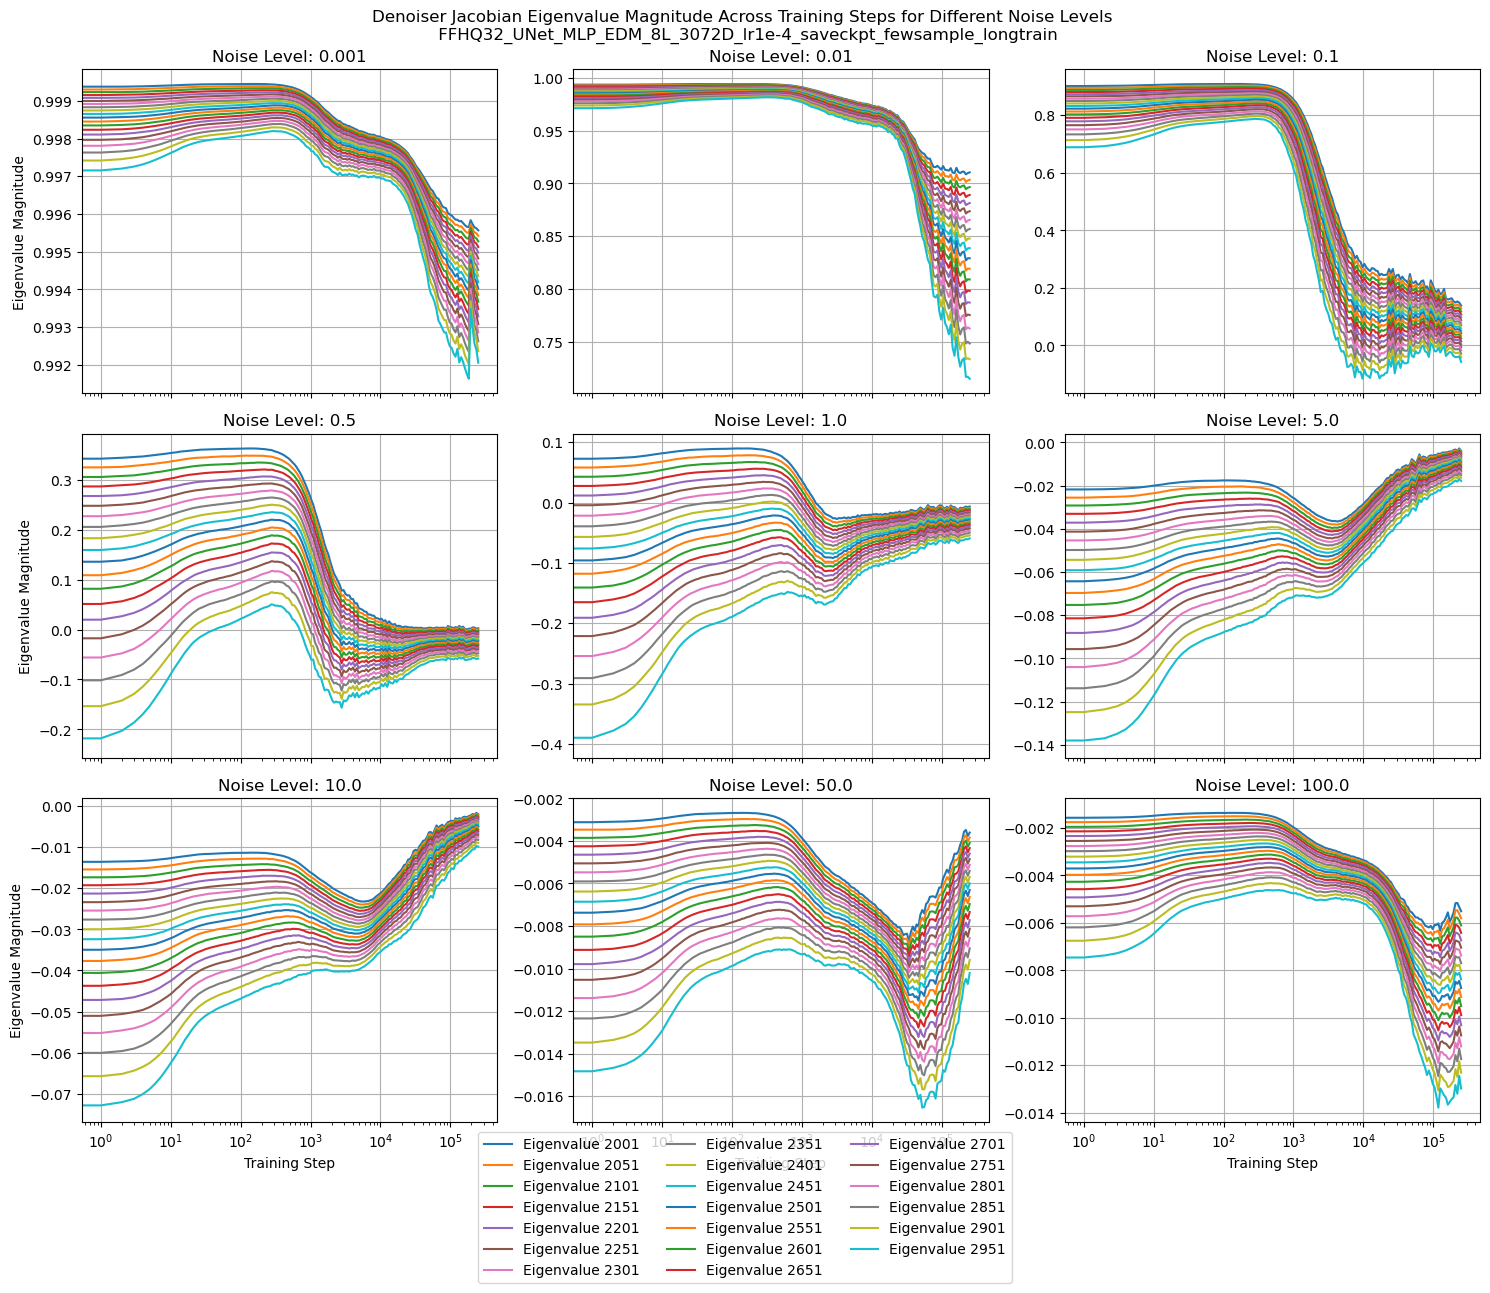

In [80]:
# Example usage
eigid2show = range(2000,3000,50)
fig = plot_eigenvalue_evolution(step_list, eigvals_tsrs, expname, eigid2show)
plt.show()

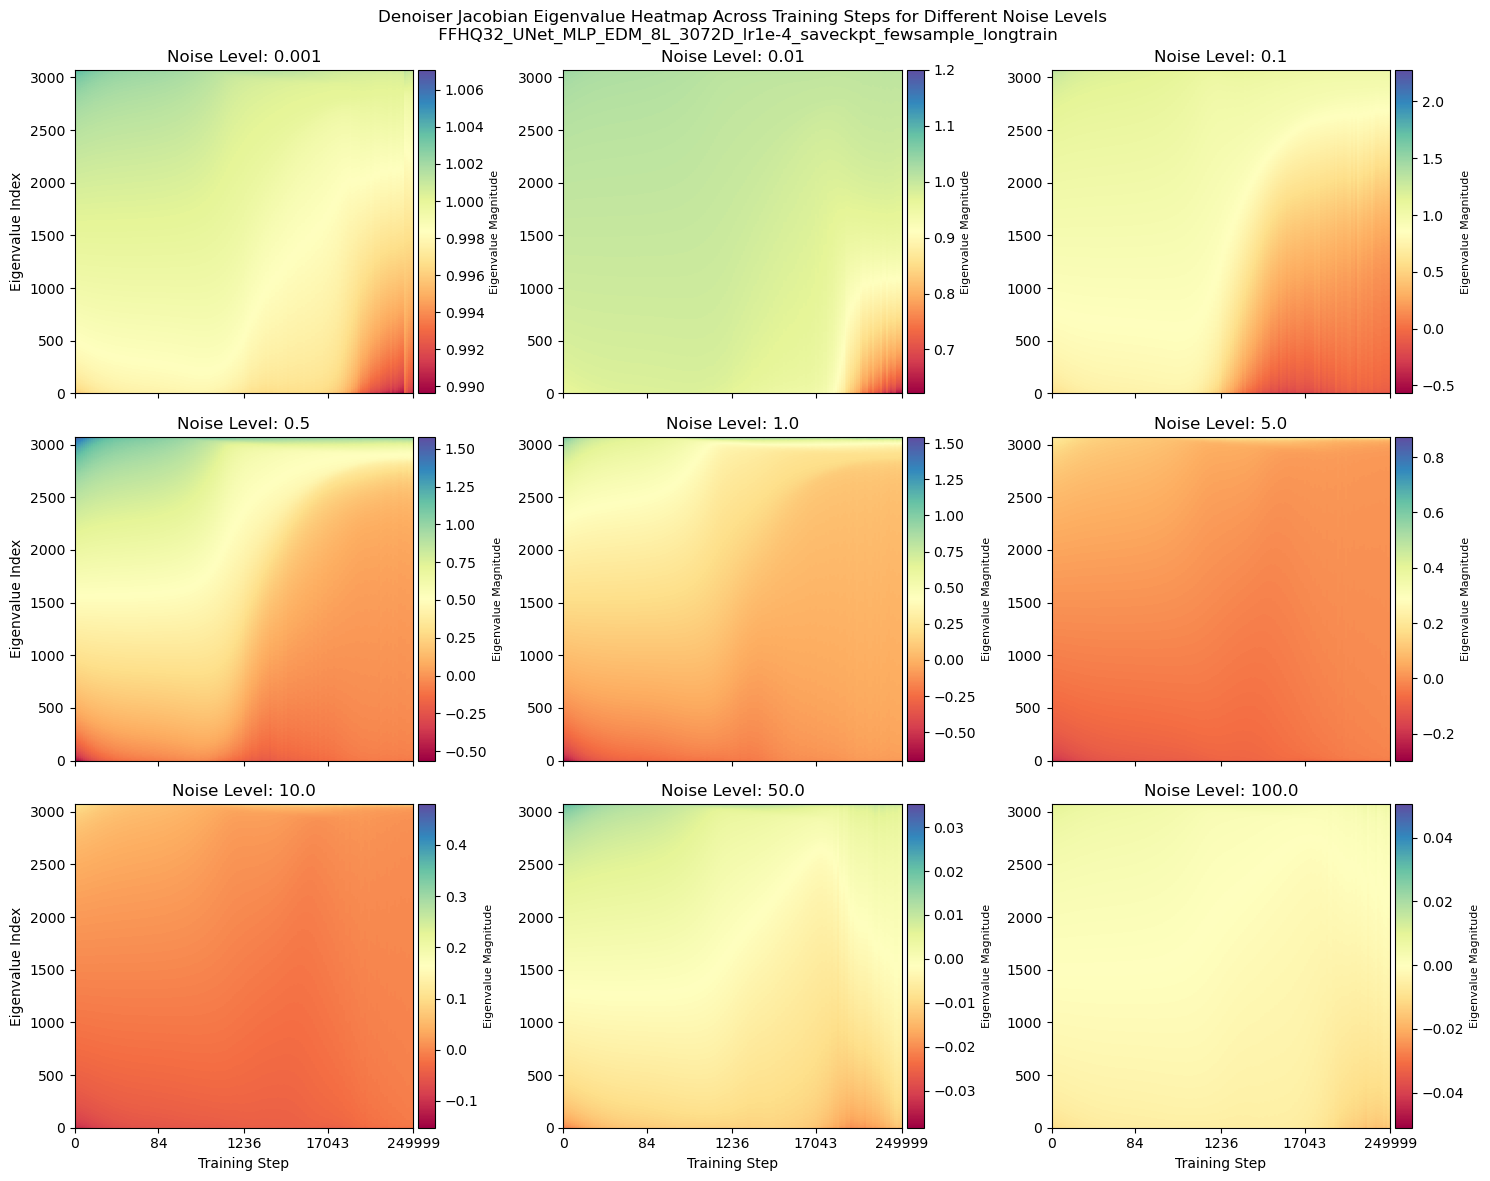

In [65]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Create a figure with subplots to compare different noise levels
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=False)
axes = axes.flatten()
# Plot heatmaps of all eigenvalues for different noise levels
for i, noise_level in enumerate(list(eigvals_tsrs.keys())[:9]):  # Up to 9 noise levels
    ax = axes[i]
    eigvals_tensor = eigvals_tsrs[noise_level]
    assert eigvals_tensor.shape[0] == len(step_list)
    # Create heatmap of all eigenvalues
    im = ax.imshow(eigvals_tensor.T, aspect='auto', cmap='Spectral',
                  extent=[0, len(step_list)-1, 0, eigvals_tensor.shape[1]-1],
                  origin='upper', interpolation='none')
    # Set x-ticks to correspond to step_list (in log scale)
    ax.set_title(f'Noise Level: {noise_level}')
    # Create custom x-ticks for log scale
    log_step_positions = np.linspace(0, len(step_list)-1, 5).astype(int)
    ax.set_xticks(log_step_positions)
    ax.set_xticklabels([f"{step_list[pos]}" for pos in log_step_positions])
    
    if i % 3 == 0:  # Left column
        ax.set_ylabel('Eigenvalue Index')
    if i >= 6:  # Bottom row
        ax.set_xlabel('Training Step')
    
    # Add individual colorbar for each subplot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Eigenvalue Magnitude', fontsize=8)

plt.suptitle(f'Denoiser Jacobian Eigenvalue Heatmap Across Training Steps for Different Noise Levels \n {expname}')
plt.tight_layout()
plt.show()


### Scratch

Processed step 0
Processed step 10
Processed step 21
Processed step 39
Processed step 74
Processed step 138
Processed step 259
Processed step 484
Processed step 905
Processed step 1690
Processed step 3156
Processed step 5894
Processed step 11007
Processed step 20555
Processed step 38386
Processed step 71686
Processed step 133871
Processed step 249999


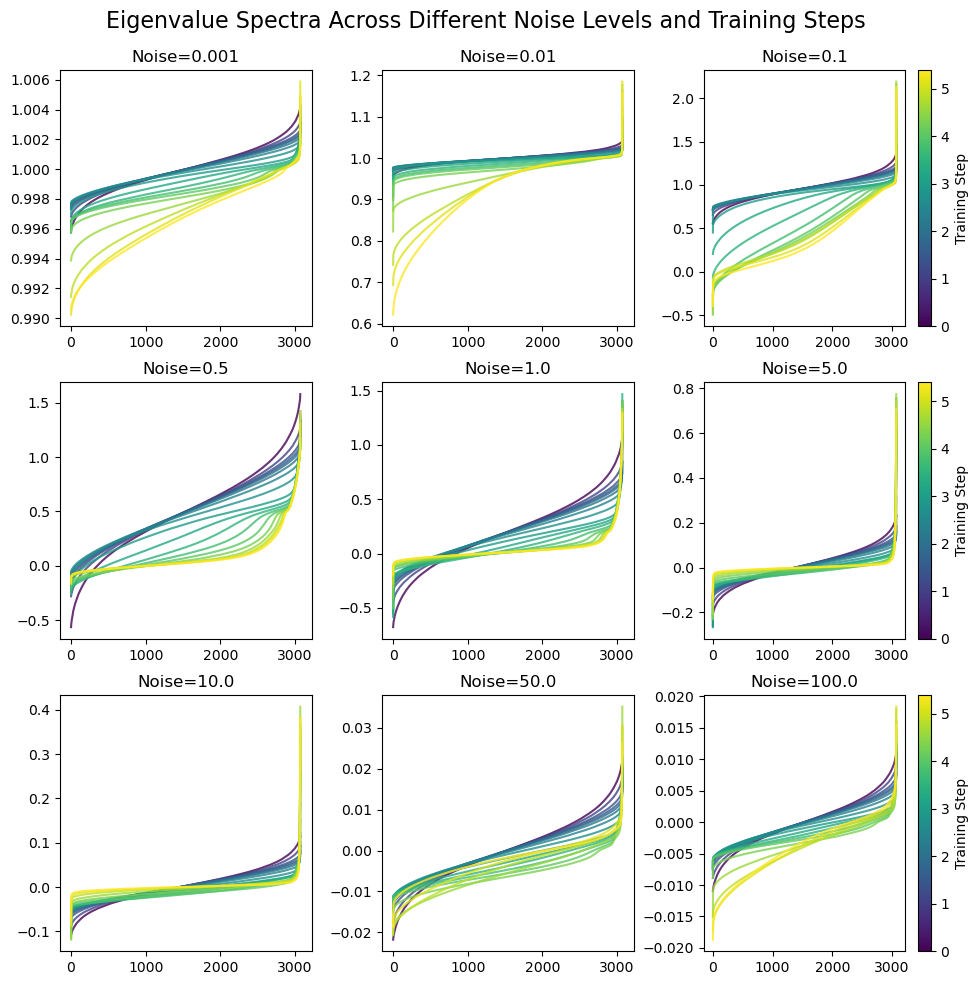

In [23]:


fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()
# Plot all eigenvalues on the appropriate subplots
for idx, (noise, eigvals_list) in enumerate(all_eigvals.items()):
    if idx < 9:  # We have 9 subplots
        ax = axes[idx]
        for step, eigvals_np in eigvals_list:
            color = cmap(norm(np.log10(step+1)))
            ax.plot(eigvals_np, color=color, alpha=0.8)
        
        ax.set_title(f"Noise={noise}")
        
        # Add a colorbar to show step progression
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        if idx % 3 == 2:  # Add colorbar to rightmost plots
            cbar = plt.colorbar(sm, ax=ax)
            cbar.set_label('Training Step')

# Add a common title and adjust layout
plt.tight_layout()
plt.suptitle("Eigenvalue Spectra Across Different Noise Levels and Training Steps", fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

Processed step 0
Processed step 1
Processed step 2
Processed step 3
Processed step 4
Processed step 5
Processed step 6
Processed step 7
Processed step 8
Processed step 9
Processed step 10
Processed step 11
Processed step 12
Processed step 13
Processed step 14
Processed step 15
Processed step 16
Processed step 17
Processed step 18
Processed step 20
Processed step 21
Processed step 22
Processed step 24
Processed step 25
Processed step 27
Processed step 29
Processed step 31
Processed step 33
Processed step 35
Processed step 37
Processed step 39
Processed step 42
Processed step 45
Processed step 48
Processed step 51
Processed step 54
Processed step 57
Processed step 61
Processed step 65
Processed step 69
Processed step 74
Processed step 79
Processed step 84
Processed step 89
Processed step 95
Processed step 101
Processed step 108
Processed step 115
Processed step 122
Processed step 130
Processed step 138
Processed step 147
Processed step 157
Processed step 167
Processed step 178
Processed 

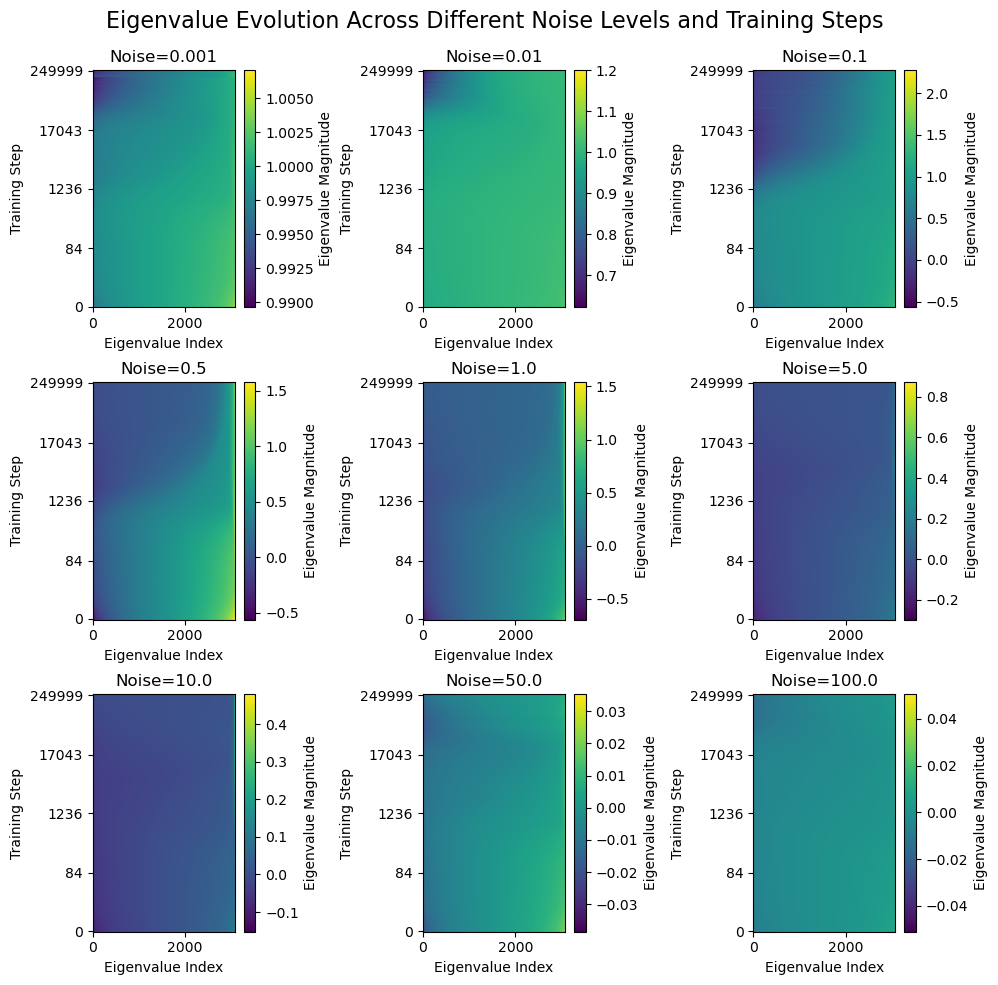

In [26]:
import matplotlib
# Define the steps to load
steps = step_list
# Create a colormap for visualizing progression
cmap = matplotlib.cm.viridis
# norm = matplotlib.colors.Normalize(np.log10(min(steps) + 1), np.log10(max(steps) + 1))

# Dictionary to store eigenvalues for each noise level and step
all_eigvals = {}
# Process each step
for step_idx, step in enumerate(steps):
    jacob_file_path = join(jacob_dir, f"jacobian_ref_img_w_noise_step{step:06d}.pth")
    try:
        jacob_store = torch.load(jacob_file_path)
        
        # Plot for each noise level
        for idx, (key, entry_type) in enumerate(jacob_store.keys()):
            if entry_type == "jacobian":
                noise = key
                jacobian = jacob_store[noise, "jacobian"]
                # Perform eigen decomposition
                eigvals, eigvecs = torch.linalg.eigh(jacobian.cuda())
                # eigvals = torch.linalg.eigvals(jacobian.cuda())
                eigvals_np = eigvals.cpu().numpy()
                # Find the subplot index for this noise level
                if noise not in all_eigvals:
                    all_eigvals[noise] = []
                all_eigvals[noise].append((step, eigvals_np))
        print(f"Processed step {step}")
    except FileNotFoundError:
        print(f"File not found for step {step}")

# Create a new visualization with colormaps for each noise level
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

# Plot eigenvalue evolution as colormaps
for idx, (noise, eigvals_list) in enumerate(all_eigvals.items()):
    if idx < 9:  # We have 9 subplots
        ax = axes[idx]
        
        # Sort by step for proper ordering
        eigvals_list.sort(key=lambda x: x[0])
        
        # Create a 2D array where each row represents eigenvalues at a step
        steps_for_noise = [item[0] for item in eigvals_list]
        eigenvalue_matrix = np.array([item[1] for item in eigvals_list])
        
        # Get the number of eigenvalues
        n_eigenvalues = eigenvalue_matrix.shape[1]
        
        # Create a meshgrid for plotting
        step_indices = np.arange(len(steps_for_noise))
        eigenvalue_indices = np.arange(n_eigenvalues)
        X, Y = np.meshgrid(eigenvalue_indices, step_indices)
        
        # Plot as a colormap
        im = ax.pcolormesh(X, Y, eigenvalue_matrix, cmap='viridis', shading='auto')
        
        # Set y-ticks to show actual step values (use a subset for clarity)
        y_tick_indices = np.linspace(0, len(steps_for_noise)-1, min(5, len(steps_for_noise))).astype(int)
        ax.set_yticks(y_tick_indices)
        ax.set_yticklabels([str(steps_for_noise[i]) for i in y_tick_indices])
        
        ax.set_title(f"Noise={noise}")
        ax.set_xlabel("Eigenvalue Index")
        ax.set_ylabel("Training Step")
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Eigenvalue Magnitude')

# Add a common title and adjust layout
plt.tight_layout()
plt.suptitle("Eigenvalue Evolution Across Different Noise Levels and Training Steps", fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

In [ ]:
# save a eigenvalue collection 
# Save eigenvalue collection to a file for later analysis
import pickle
import os
# Create a directory for saved data if it doesn't exist
# save_dir = "saved_data"
# os.makedirs(save_dir, exist_ok=True)
# Save the eigenvalue collection
save_path = os.path.join(jacob_dir, "eigenvalue_collection.pkl")
with open(save_path, "wb") as f:
    pickle.dump(all_eigvals, f)

print(f"Eigenvalue collection saved to {save_path}")
for noise, eigvals_list in all_eigvals.items():
    # Sort by step for proper ordering
    eigvals_list.sort(key=lambda x: x[0])
    # Extract steps and eigenvalues
    steps = np.array([item[0] for item in eigvals_list])
    eigenvalues = np.array([item[1] for item in eigvals_list])
    # Save both steps and eigenvalues


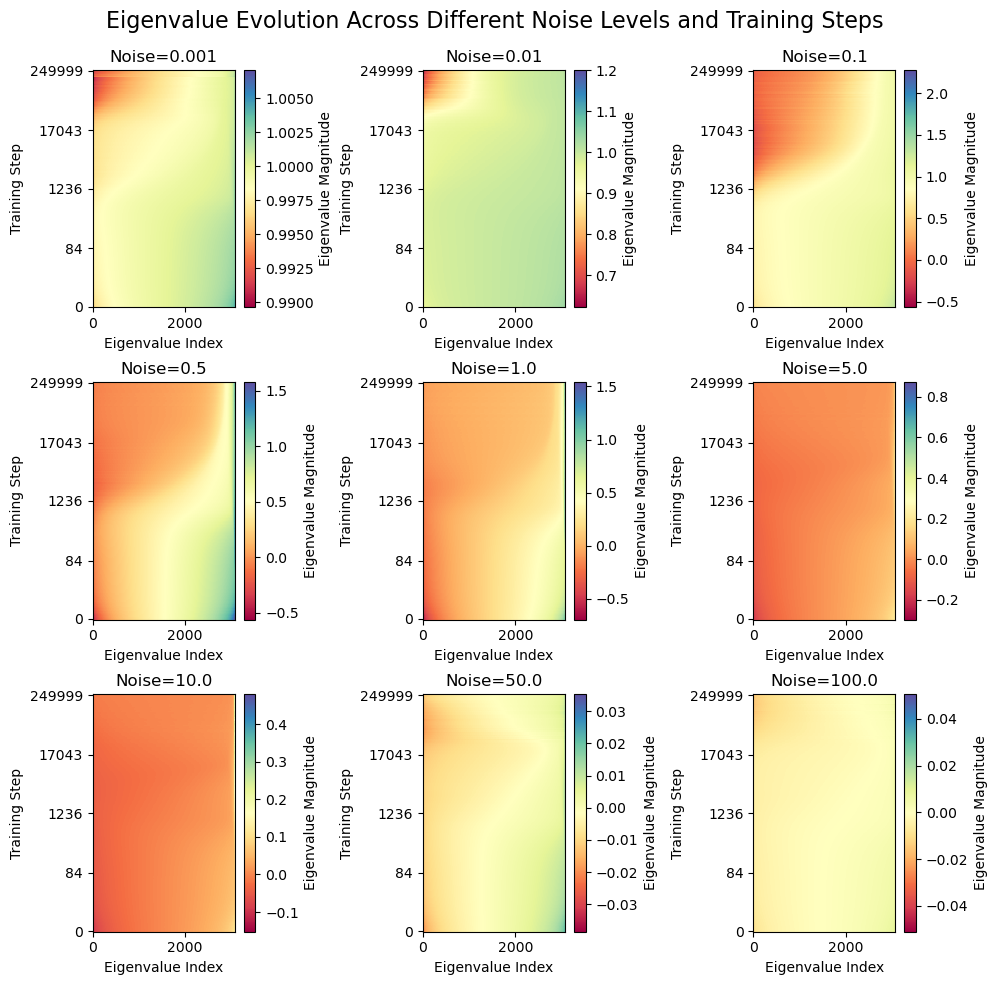

In [27]:

# Create a new visualization with colormaps for each noise level
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

# Plot eigenvalue evolution as colormaps
for idx, (noise, eigvals_list) in enumerate(all_eigvals.items()):
    if idx < 9:  # We have 9 subplots
        ax = axes[idx]
        
        # Sort by step for proper ordering
        eigvals_list.sort(key=lambda x: x[0])
        
        # Create a 2D array where each row represents eigenvalues at a step
        steps_for_noise = [item[0] for item in eigvals_list]
        eigenvalue_matrix = np.array([item[1] for item in eigvals_list])
        
        # Get the number of eigenvalues
        n_eigenvalues = eigenvalue_matrix.shape[1]
        
        # Create a meshgrid for plotting
        step_indices = np.arange(len(steps_for_noise))
        eigenvalue_indices = np.arange(n_eigenvalues)
        X, Y = np.meshgrid(eigenvalue_indices, step_indices)
        
        # Plot as a colormap
        im = ax.pcolormesh(X, Y, eigenvalue_matrix, cmap='Spectral', shading='auto')
        
        # Set y-ticks to show actual step values (use a subset for clarity)
        y_tick_indices = np.linspace(0, len(steps_for_noise)-1, min(5, len(steps_for_noise))).astype(int)
        ax.set_yticks(y_tick_indices)
        ax.set_yticklabels([str(steps_for_noise[i]) for i in y_tick_indices])
        
        ax.set_title(f"Noise={noise}")
        ax.set_xlabel("Eigenvalue Index")
        ax.set_ylabel("Training Step")
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Eigenvalue Magnitude')

# Add a common title and adjust layout
plt.tight_layout()
plt.suptitle("Eigenvalue Evolution Across Different Noise Levels and Training Steps", fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

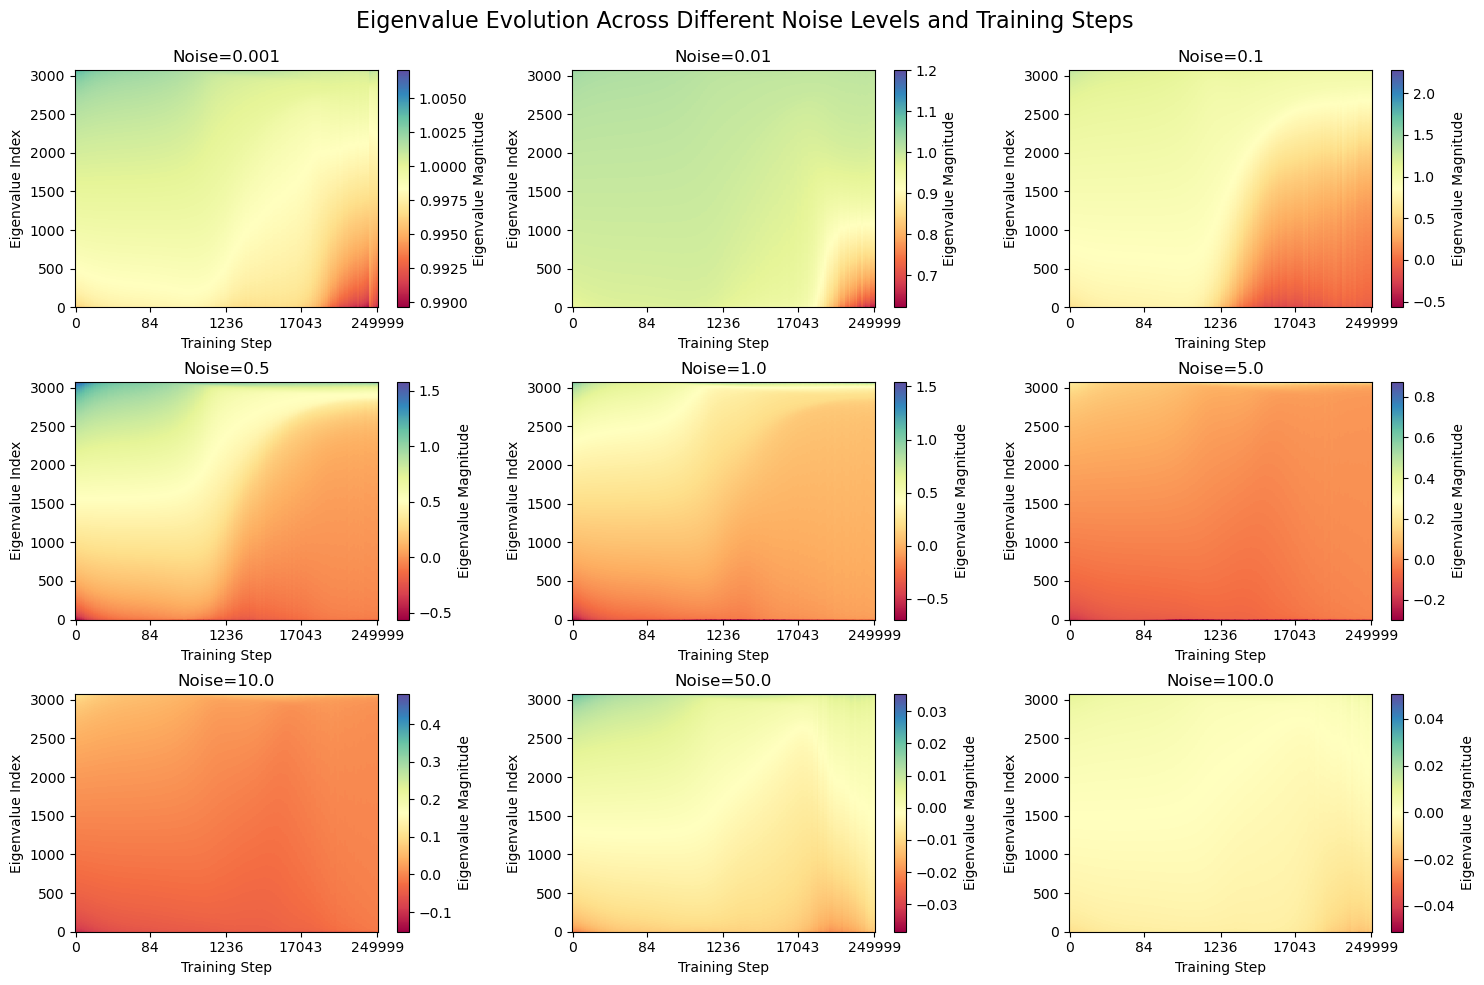

In [32]:
# Create a new visualization with colormaps for each noise level
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot eigenvalue evolution as colormaps
for idx, (noise, eigvals_list) in enumerate(all_eigvals.items()):
    if idx < 9:  # We have 9 subplots
        ax = axes[idx]
        # Sort by step for proper ordering
        eigvals_list.sort(key=lambda x: x[0])
        # Create a 2D array where each row represents eigenvalues at a step
        steps_for_noise = [item[0] for item in eigvals_list]
        eigenvalue_matrix = np.array([item[1] for item in eigvals_list])
        # Get the number of eigenvalues
        n_eigenvalues = eigenvalue_matrix.shape[1]
        
        # Create a meshgrid for plotting - transposed from original
        step_indices = np.arange(len(steps_for_noise))
        eigenvalue_indices = np.arange(n_eigenvalues)
        X, Y = np.meshgrid(step_indices, eigenvalue_indices)
        
        # Plot as a colormap - transpose the eigenvalue matrix and reverse eigenvalue order
        im = ax.pcolormesh(X, Y, eigenvalue_matrix.T[:], cmap='Spectral', shading='auto')
        
        # Set x-ticks to show actual step values (use a subset for clarity)
        x_tick_indices = np.linspace(0, len(steps_for_noise)-1, min(5, len(steps_for_noise))).astype(int)
        ax.set_xticks(x_tick_indices)
        ax.set_xticklabels([str(steps_for_noise[i]) for i in x_tick_indices])
        
        ax.set_title(f"Noise={noise}")
        ax.set_ylabel("Eigenvalue Index")
        ax.set_xlabel("Training Step")
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Eigenvalue Magnitude')

# Add a common title and adjust layout
plt.tight_layout()
plt.suptitle("Eigenvalue Evolution Across Different Noise Levels and Training Steps", fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

### DiT

In [7]:
from collections import defaultdict
import re

In [ ]:
exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"
expname = "FFHQ32_DiT_P2_384D_6H_6L_EDM_saveckpt_fewsample_longtrain"
expdir = join(exproot, expname)
jacob_dir = join(expdir, "jacobian_store")
jacob_files = sorted(glob(join(jacob_dir, "jacobian_ref_img_w_noise_step*.pth")))
# Extract step numbers from filenames using regex
step_list = []
for file_path in jacob_files:
    match = re.search(r'jacobian_ref_img_w_noise_step(\d+)\.pth', file_path)
    if match:
        step_list.append(int(match.group(1)))

# Sort files by step number
step_list = sorted(step_list)
print(step_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 29, 31, 33, 35, 37, 39, 42, 45, 48, 51, 54, 57, 61, 65, 69, 74, 79, 84, 89, 95, 101, 108, 115, 122, 130, 138, 147, 157, 167, 178, 189, 202, 215, 229, 243, 259, 276, 294, 312, 333, 354, 377, 401, 427, 455, 484, 515, 549, 584, 622, 662, 704, 750, 798, 850, 905, 963, 1025, 1091, 1161, 1236, 1316, 1401, 1491, 1587, 1690, 1799, 1914, 2038, 2169, 2309, 2458, 2616, 2785, 2965, 3156, 3359, 3576, 3806, 4052, 4313, 4591, 4887, 5202, 5537, 5894, 6274, 6678, 7108, 7566, 8054, 8573, 9126, 9714, 10340, 11007, 11716, 12471, 13275, 14131, 15041, 16011, 17043, 18141, 19310, 20555, 21880, 23290, 24791, 26389, 28090, 29900, 31827, 33879, 36062, 38386, 40860, 43494, 46297, 49281, 52457, 55838, 59437, 63268, 67345, 71686, 76306, 81224, 86459, 92031, 97962, 104276, 110997, 118151, 125765, 133871, 142499, 151683, 161459, 171865, 182942, 194733, 207283, 220643, 234863, 249999]


In [36]:
# Dictionary to store eigenvalues for each noise level and step
all_eigvals_col = {}
# Process each jacobian file
for step in tqdm(step_list):
    file_path = join(jacob_dir, f"jacobian_ref_img_w_noise_step{step:06d}.pth")
    if not os.path.exists(file_path):
        continue
    # Load the jacobian data
    jacob_data = torch.load(file_path)
    # Process each noise level in the jacobian data
    for noise_level, data_type in jacob_data:
        if data_type != "jacobian":
            continue
        # Compute eigenvalues
        jacob_matrix = jacob_data[noise_level, "jacobian"]
        eigvals = torch.linalg.eigvalsh(jacob_matrix.cuda())
        # Sort eigenvalues in descending order
        eigvals = torch.sort(eigvals.cpu(), dim=-1, descending=True).values
        # Store the eigenvalues with the step number
        all_eigvals_col[(noise_level, step)] = eigvals

100%|██████████| 171/171 [02:27<00:00,  1.16it/s]


In [45]:
eigvals_mats = defaultdict(list)
noise_levels = sorted(np.unique([noise_level for noise_level, step in all_eigvals_col.keys()]))
step_list = sorted(np.unique([step for noise_level, step in all_eigvals_col.keys()]))
# for noise_level, step in all_eigvals_col.keys():
for noise_level in noise_levels:
    for step in step_list:
        eigvals = all_eigvals_col[(noise_level, step)]
        eigvals_mats[noise_level].append(eigvals)

eigvals_tsrs = dict()
for noise_level in eigvals_mats:
    eigvals_tsrs[noise_level] = torch.stack(eigvals_mats[noise_level], dim=0)

In [46]:
eigvals_tsrs.keys()

dict_keys([0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0])

In [47]:
eigvals_tsrs[100.0].shape

torch.Size([171, 3072])

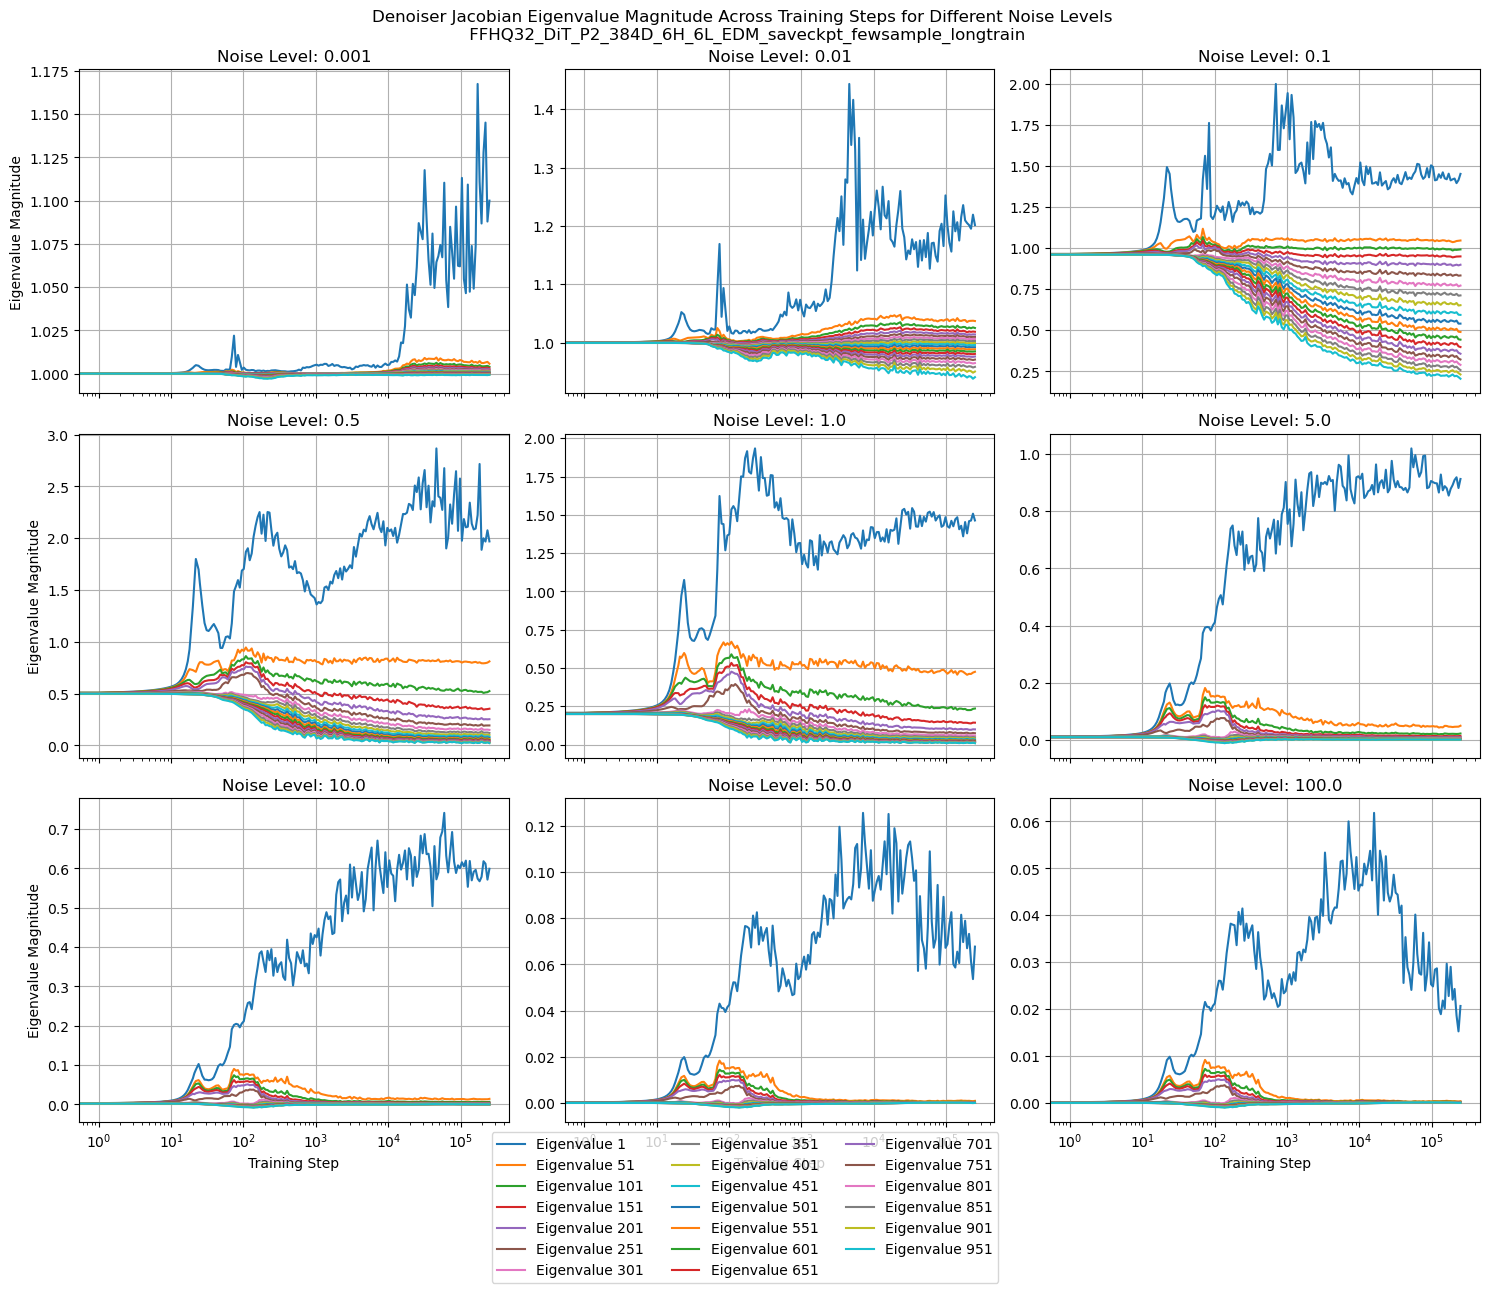

In [57]:
eigid2show = range(0,1000,50)

# Create a figure with subplots to compare different noise levels
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=False)
axes = axes.flatten()
# Plot the first eigenvalue for different noise levels
for i, noise_level in enumerate(list(eigvals_tsrs.keys())[:9]):  # Up to 9 noise levels
    ax = axes[i]
    eigvals_tensor = eigvals_tsrs[noise_level]
    # Plot the top 3 eigenvalues
    for j in eigid2show:
        ax.plot(step_list, eigvals_tensor[:, j], label=f'Eigenvalue {j+1}')
    ax.set_title(f'Noise Level: {noise_level}')
    ax.grid(True)
    # ax.set_yscale('log')
    ax.set_xscale('log')
    if i % 3 == 0:  # Left column
        ax.set_ylabel('Eigenvalue Magnitude')
    if i >= 6:  # Bottom row
        ax.set_xlabel('Training Step')

plt.suptitle(f'Denoiser Jacobian Eigenvalue Magnitude Across Training Steps for Different Noise Levels \n {expname}')
plt.tight_layout()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3)
plt.show()


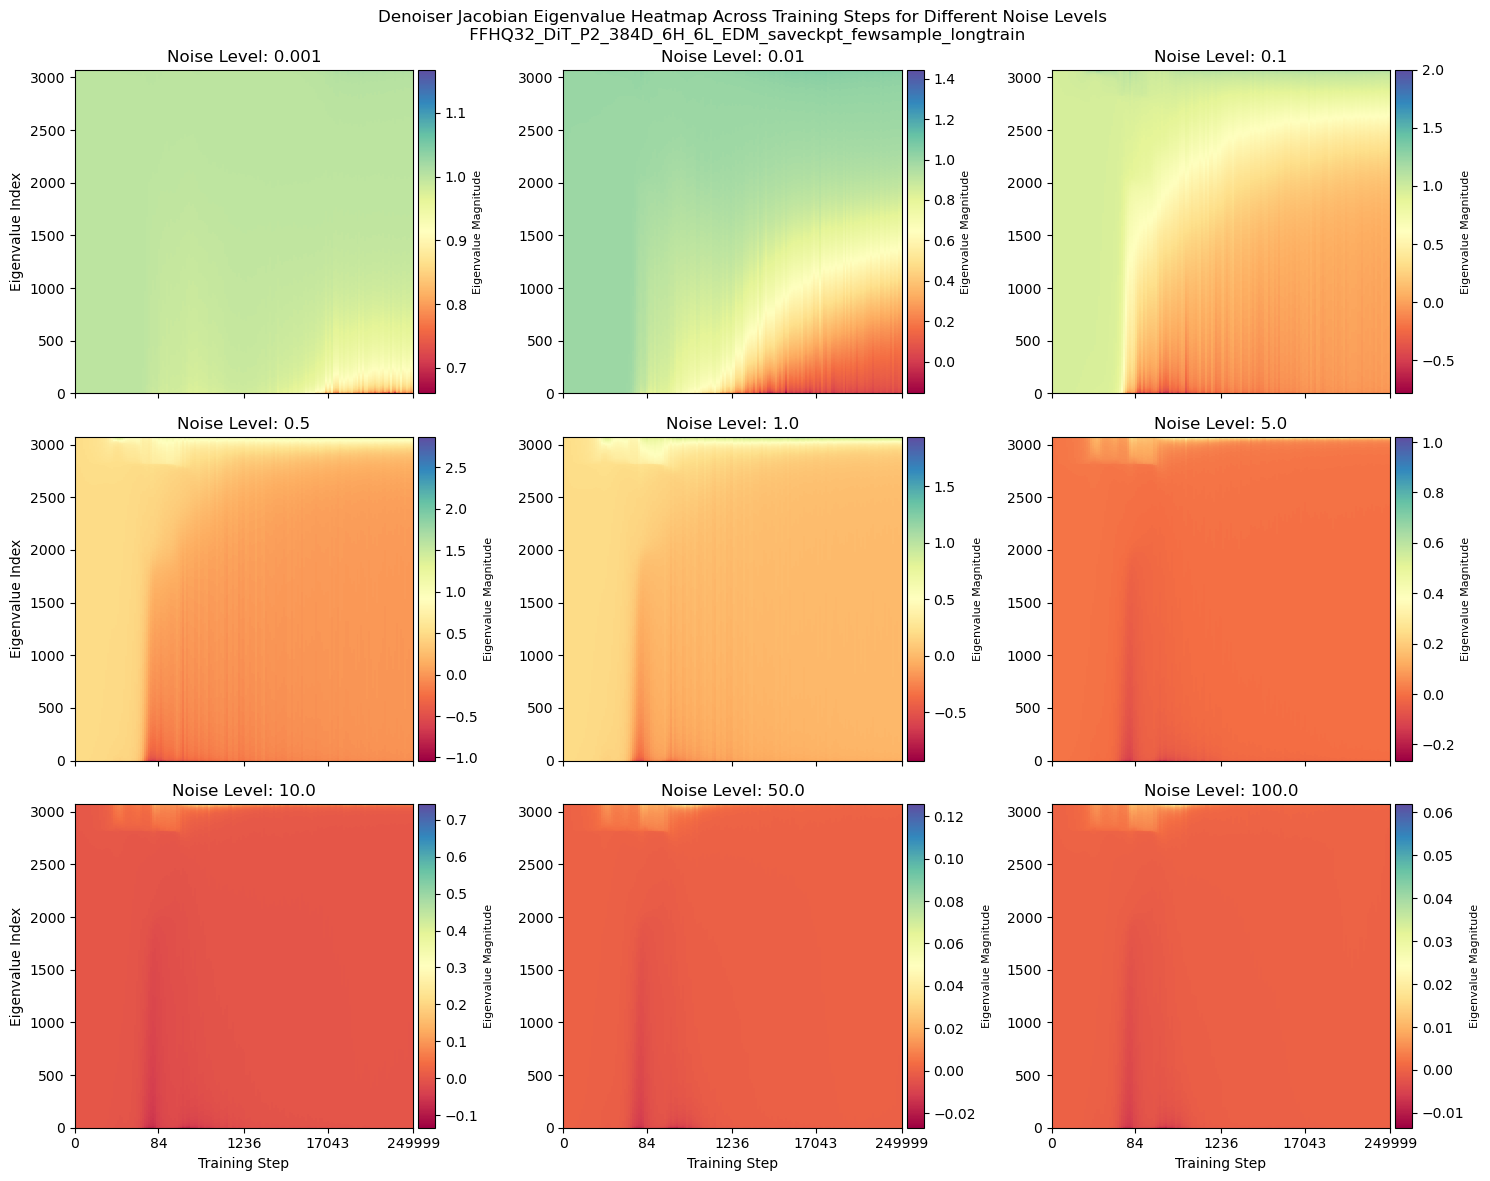

In [62]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Create a figure with subplots to compare different noise levels
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=False)
axes = axes.flatten()
# Plot heatmaps of all eigenvalues for different noise levels
for i, noise_level in enumerate(list(eigvals_tsrs.keys())[:9]):  # Up to 9 noise levels
    ax = axes[i]
    eigvals_tensor = eigvals_tsrs[noise_level]
    assert eigvals_tensor.shape[0] == len(step_list)
    # Create heatmap of all eigenvalues
    im = ax.imshow(eigvals_tensor.T, aspect='auto', cmap='Spectral',
                  extent=[0, len(step_list)-1, 0, eigvals_tensor.shape[1]-1],
                  origin='upper', interpolation='none')
    # Set x-ticks to correspond to step_list (in log scale)
    ax.set_title(f'Noise Level: {noise_level}')
    # Create custom x-ticks for log scale
    log_step_positions = np.linspace(0, len(step_list)-1, 5).astype(int)
    ax.set_xticks(log_step_positions)
    ax.set_xticklabels([f"{step_list[pos]}" for pos in log_step_positions])
    
    if i % 3 == 0:  # Left column
        ax.set_ylabel('Eigenvalue Index')
    if i >= 6:  # Bottom row
        ax.set_xlabel('Training Step')
    
    # Add individual colorbar for each subplot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Eigenvalue Magnitude', fontsize=8)

plt.suptitle(f'Denoiser Jacobian Eigenvalue Heatmap Across Training Steps for Different Noise Levels \n {expname}')
plt.tight_layout()
plt.show()
